In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

2024-04-15 15:00:07.889559: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:00:07.967402: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:00:07.968823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 15:00:08.881549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [3]:
train_ds = train.flow_from_directory('/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train',
                                     target_size = (224,224), batch_size = 10)

test_ds = test.flow_from_directory('/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/test',
                                  target_size = (224,224), batch_size = 10)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [5]:
# Set up your data generator using flow_from_directory
train_generator = train.flow_from_directory(
    '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train',
    target_size=(224, 224),  
    batch_size=10,
    class_mode='binary')

Found 251 images belonging to 3 classes.


In [21]:
# Set up your data generator using flow_from_directory
test_generator = test.flow_from_directory(
    '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/test',
    target_size=(224, 224),  
    batch_size=10,
    class_mode='binary')

Found 66 images belonging to 3 classes.


In [6]:
class_names = list(train_generator.class_indices.keys())
print("Class Labels:", class_names)

Class Labels: ['Covid', 'Normal', 'Viral Pneumonia']


# Data Augmentation

In [7]:
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomHeight, RandomWidth, Dense, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [8]:
augmentation_layer = Sequential([
    RandomFlip("horizontal", seed=42),
    RandomRotation(0.2, seed=42),
    RandomZoom(0.2, seed=42),
    RandomHeight(0.2, seed=42),
    RandomWidth(0.2, seed=42),
    Rescaling(1/255.)
], name="augmentation_layer")

augmentation_layer

2024-04-15 15:00:46.277229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 15:00:46.277820: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
import random
target_dir = "/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train"
target_class = random.choice(class_names)
target_dir = f"{target_dir}/{target_class}"
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

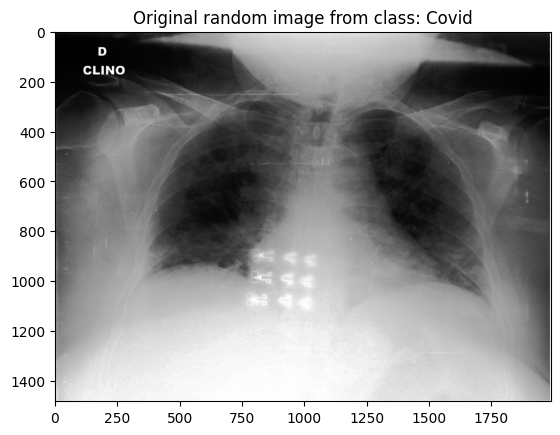

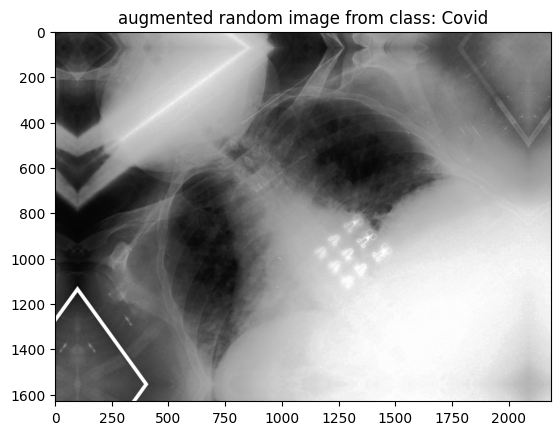

In [12]:
import matplotlib.image as mpimg

img = mpimg.imread(random_image_path)
plt.title(f"Original random image from class: {target_class}")
# plt.axis(False)
plt.imshow(img);

# Now lets plot our augmented random image
augmented_image = augmentation_layer(img, training=True)
plt.figure()
plt.title(f"augmented random image from class: {target_class}")
plt.imshow(augmented_image)

# Train Augmented Images

In [14]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

# Input layer
input_layer = tf.keras.layers.Input(shape=(244,244) + (3, ), name="input_layer")
x = augmentation_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
x = Dense(300, activation=tf.keras.activations.relu)(x)
output_layer = Dense(len(class_names), activation=softmax, name="output_layer")(x)

model_1 = tf.keras.Model(input_layer, output_layer)

In [16]:
model_1.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"]
)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, 3)          0         
 ial)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 300)               384300    
                                                             